# Cognition & Computation - Project


+ Mattia Varagnolo
+ id: 2078225
+ 17/12/2023

# Setup

In [1]:
# current working directory
import os
import sys
import time

getcwd = os.getcwd()
print(getcwd)


/content


In [2]:
import requests

def _get_files_from_repo(files, repo):
    repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/"
    for file in files:
        response = requests.get(f"{repository_url}{file}")
        if response.status_code == 200:
            with open(file, 'wb') as f:
                f.write(response.content)
                print(f"Downloaded {file} from {repository_url}")
        else:
            print(f"Failed to download {file}. Status code: {response.status_code}")

files = ["DBN.py", "RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")


Downloaded DBN.py from https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/
Downloaded RBM.py from https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/


In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster as cluster
import torch
import torch.nn.functional as functional
import torchvision as tv
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler

from DBN import DBN

### Data preprocessing

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [5]:
# get training and test set from the library
training_set = tv.datasets.FashionMNIST('data/', train=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()]), download=True)
test_set = tv.datasets.FashionMNIST('data/', train=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()]), download=True)

print(f"Training set size: {len(training_set)}")
print(f"Test set size: {len(test_set)}")

100%|██████████| 26421880/26421880 [00:01<00:00, 16696308.49it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 331346.11it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5621280.57it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23649810.51it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Training set size: 60000
Test set size: 10000


In [6]:
# normalize data
training_set.data = (training_set.data.type(torch.FloatTensor)/255)
test_set.data = (test_set.data.type(torch.FloatTensor)/255)

print('Data normalized')

Data normalized


In [7]:
# save them to the device
training_set.data = training_set.data.to(device)
test_set.data = test_set.data.to(device)
training_set.targets = training_set.targets.to(device)
test_set.targets = test_set.targets.to(device)

class label: Trouser


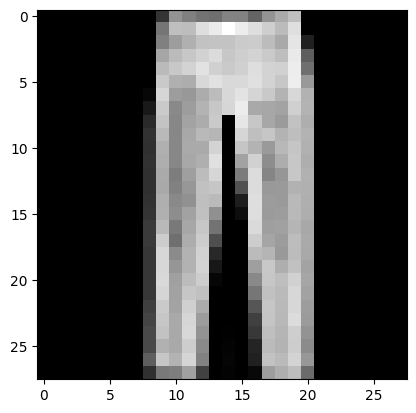

In [8]:
# get classes and targets
classes = training_set.classes
targets = training_set.targets.to("cpu").numpy()
# show a random example from the training set
index = 16
img = training_set.data[index]
print(f"class label: {classes[targets[index]]}" )
# plot it
__ = plt.imshow(img.reshape(28,28).to('cpu'), cmap="gray")
plt.show()

## Model Training

In [9]:
# hyperparameters
hidden_units = [400, 650, 650, 600]
num_epochs = 50
batch_size = 120
learning_rate = 0.1

In [11]:
# creation of the deep boltzmann machine
dbn_fmnist = DBN(
    visible_units=28*28,
    hidden_units=hidden_units,
    k=1,
    learning_rate=learning_rate,
    learning_rate_decay=False,
    initial_momentum=0.5,
    final_momentum=0.9,
    weight_decay=0.0001,
    xavier_init=False,
    increase_to_cd_k=False,
    use_gpu=True
)

In [12]:
# training
dbn_fmnist.train_static(
    training_set.data,
    training_set.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8004     |0.0823       |298.9645   |8.0052     |
|20    |1.6376     |0.0767       |265.9215   |5.8175     |
|30    |1.5938     |0.0726       |257.4261   |5.3496     |
|40    |1.5731     |0.0728       |253.8440   |5.5942     |
|50    |1.5607     |0.0737       |249.9615   |5.0531     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2765     |0.0388       |158.7155   |3.2961     |
|20    |1.1488     |0.0358       |144.3263   |2.7172     |
|30    |1.1208     |0.0349       |140.8485   |3.0993     |
|40    |1.1069     |0.0351       |137.9973   |2.9229     |
|50    |1.0963     |0.0347       |136.4665   |2.6841     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.7240     |0.0251       |145.0726   |3.1918     |
|20    |0.6386     |0.0210       |133.5681   |2.604

# 1. Readout Classifiers

In [13]:
# creates a linear model to visualize hidden representations
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [14]:
# trains a linear model with a specific hidden layer representation
def train(model, input, epochs=1000):
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets = training_set.targets

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0:
      print("epoch: {:4d}/{} | loss: {:.3f}".format(epoch, epochs, loss))
  print()

In [15]:
# helps getting values from the hidden layers
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

def get_hidden_repr_layers(dataset):
  hidden_reprs_layers = [get_kth_layer_repr(dataset.data, 0, device)]
  for i in range(1, len(hidden_units)):
    hidden_reprs_layers.append(get_kth_layer_repr(hidden_reprs_layers[i-1], i, device))
  return hidden_reprs_layers

### Training of the readouts

In [16]:
# creates hidden representation for all the layers with the training set
hidden_reprs_layers = get_hidden_repr_layers(training_set)

In [17]:
# create all linear models
readouts = []
for i in range(len(hidden_units)):
  layer_size = dbn_fmnist.rbm_layers[i].W.shape[1]
  readouts.append(LinearModel(layer_size).to(device))

In [18]:
# train all of them
for readout, hidden_repr in zip(readouts, hidden_reprs_layers):
  print("===========================================")
  print(f"Training {readout}")
  train(readout, hidden_repr, epochs=2000)
  print("===========================================")

Training LinearModel(
  (linear): Linear(in_features=400, out_features=10, bias=True)
)
epoch:    0/2000 | loss: 2.317
epoch:  100/2000 | loss: 0.837
epoch:  200/2000 | loss: 0.677
epoch:  300/2000 | loss: 0.611
epoch:  400/2000 | loss: 0.571
epoch:  500/2000 | loss: 0.543
epoch:  600/2000 | loss: 0.523
epoch:  700/2000 | loss: 0.507
epoch:  800/2000 | loss: 0.494
epoch:  900/2000 | loss: 0.483
epoch: 1000/2000 | loss: 0.473
epoch: 1100/2000 | loss: 0.465
epoch: 1200/2000 | loss: 0.458
epoch: 1300/2000 | loss: 0.452
epoch: 1400/2000 | loss: 0.446
epoch: 1500/2000 | loss: 0.441
epoch: 1600/2000 | loss: 0.437
epoch: 1700/2000 | loss: 0.432
epoch: 1800/2000 | loss: 0.429
epoch: 1900/2000 | loss: 0.425

Training LinearModel(
  (linear): Linear(in_features=650, out_features=10, bias=True)
)
epoch:    0/2000 | loss: 2.243
epoch:  100/2000 | loss: 0.749
epoch:  200/2000 | loss: 0.626
epoch:  300/2000 | loss: 0.572
epoch:  400/2000 | loss: 0.539
epoch:  500/2000 | loss: 0.516
epoch:  600/2000 

### Evaluation of readouts


In [19]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [20]:
# get representation layers for the test set
hidden_reprs_layers_test = get_hidden_repr_layers(test_set)

In [21]:
# compute accuracy on testing
for i in range(len(hidden_reprs_layers_test)):
  print(f"Accuracy for readout in layer {i+1}")
  print(compute_accuracy(readouts[i](hidden_reprs_layers_test[i]), test_set.targets))

Accuracy for readout in layer 1
0.8425999879837036
Accuracy for readout in layer 2
0.8438999652862549
Accuracy for readout in layer 3
0.8446999788284302
Accuracy for readout in layer 4
0.8442999720573425


# 2. Hierarchical clustering and receptive fields



### Hierarchical clustering

In [22]:
def get_mask(label):  # we use this function to filter by class
  labels = training_set.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=classes)
  ax.set_title(title)
  plt.xticks(rotation = 45)

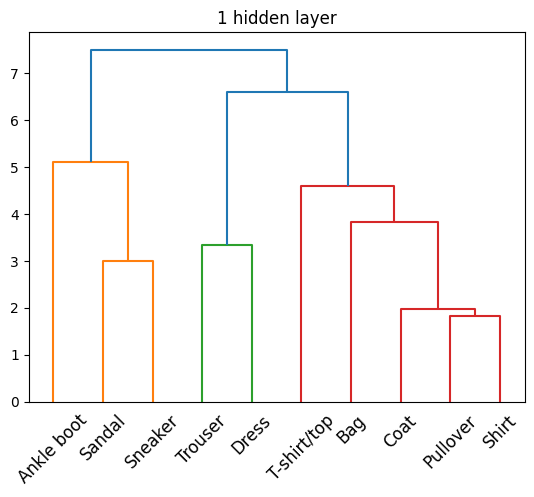

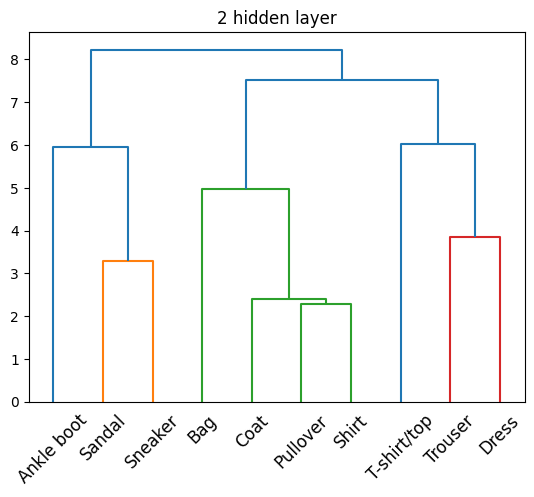

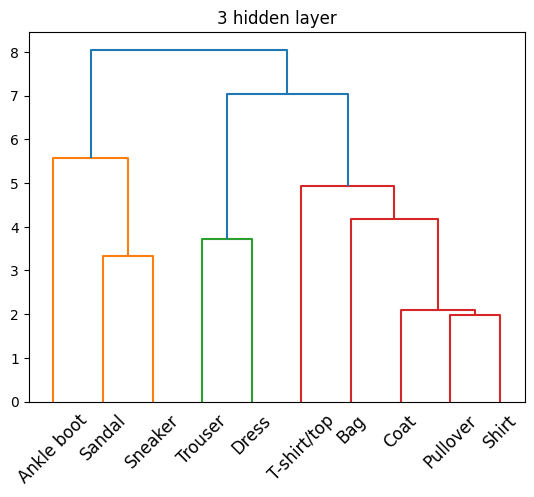

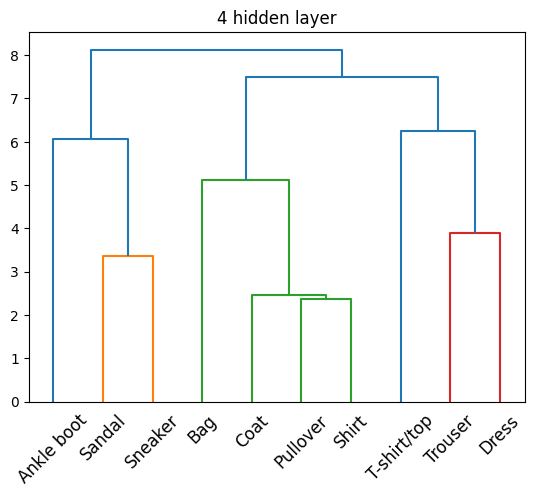

In [23]:
# get hidden representation matrix of the last layers
last_hidd_repr_matrix = get_hidden_reprs_matrix(hidden_reprs_layers[-1])

for index, layer in enumerate(hidden_reprs_layers):
  plot_dendrogram(get_hidden_reprs_matrix(layer), f"{index+1} hidden layer")

### Visual receptive fields

In [24]:
# get weights from the rbm layers
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().detach().numpy()

# show activated neurons
def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights, title=""):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap='gray')  # here we select the weights we want to plot
  plt.show()

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

In [46]:
# get learned weights to visualize
learned_weights_products = []

# first two layers
learned_weights_layer_1 = apply_threshold(get_weights(dbn_fmnist, layer=0), 0.1)
learned_weights_layer_2 = apply_threshold(get_weights(dbn_fmnist, layer=1), 0.1)
learned_weights_products.append(apply_min_max_scaler(apply_threshold((learned_weights_layer_1 @ learned_weights_layer_2), 0.1)))

# all the other layers (must project on previous projections)
for i in range(2, len(hidden_units)):
  learned_weights_layer = apply_threshold(get_weights(dbn_fmnist, layer=i), 0.1)
  learned_weights_products.append(apply_min_max_scaler(apply_threshold((learned_weights_products[i-2] @ learned_weights_layer), 0.1)))

ValueError: ignored

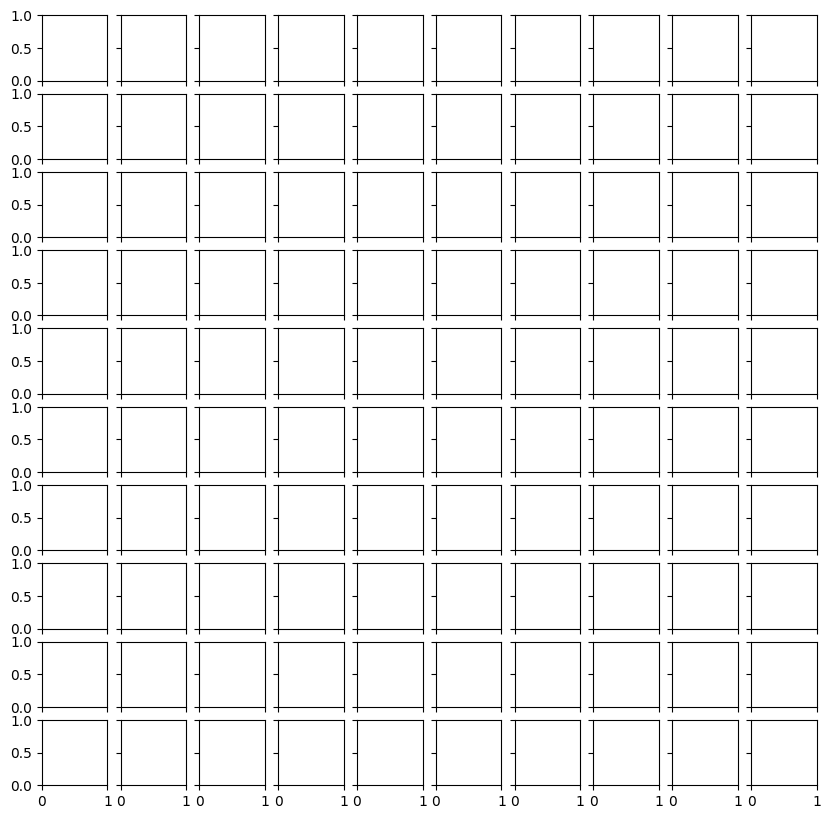

In [48]:
plot_layer_receptive_fields(learned_weights_layer_2.T)

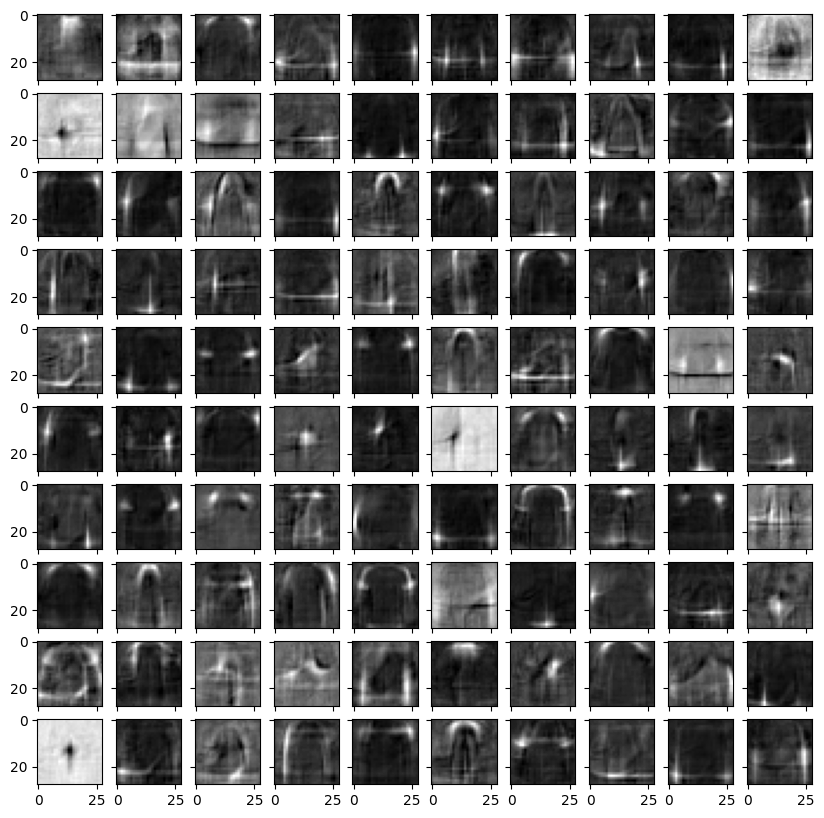

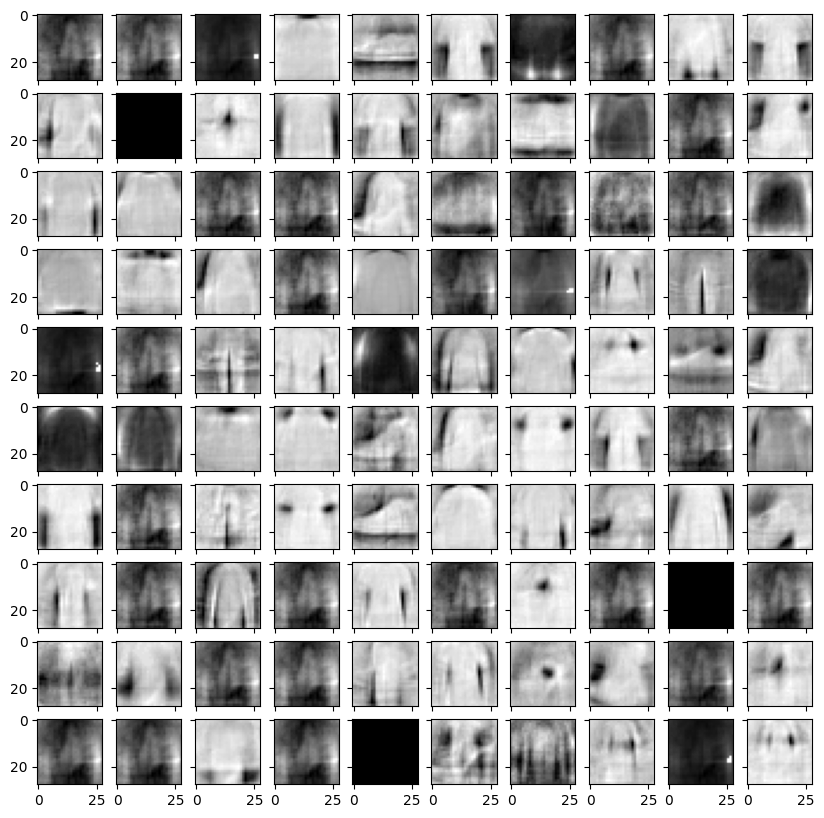

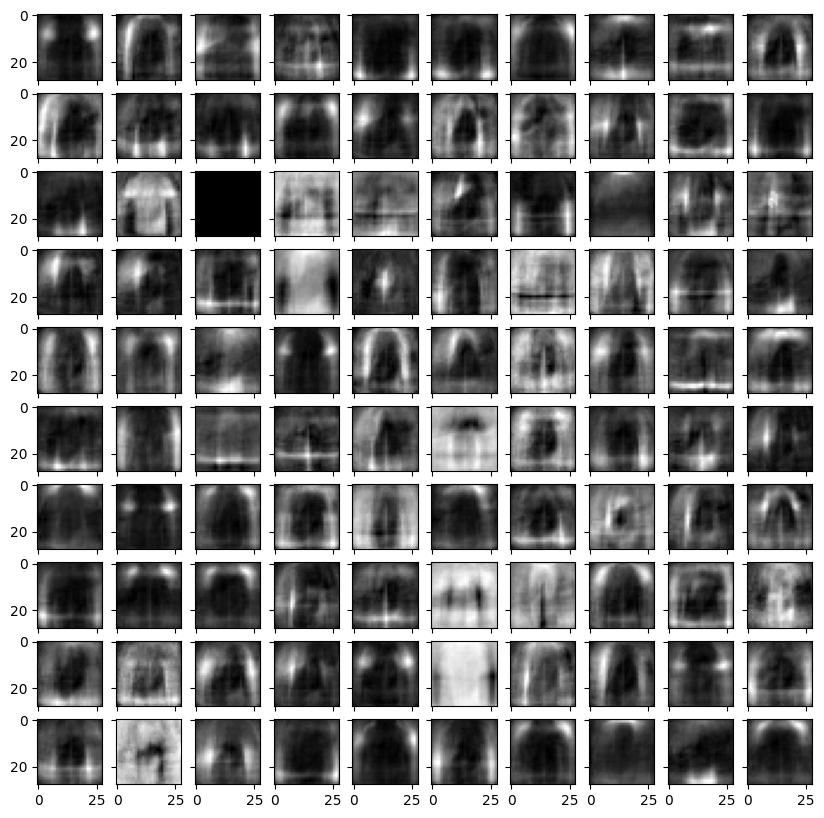

In [27]:
for index, weights_product in enumerate(learned_weights_products):
  plot_layer_receptive_fields(weights_product.T, f"{index+1} layer and {index+2} layer")

# 3. Confusion matrix and psychometric curves

### Confusion matrix

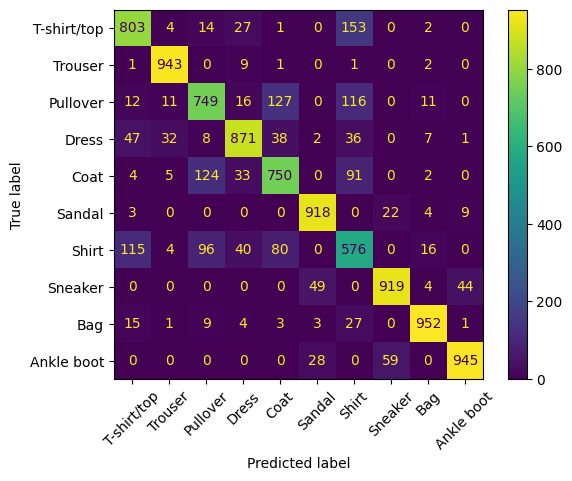

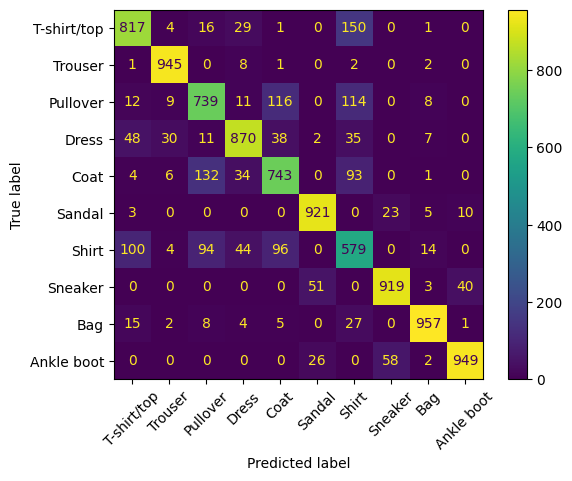

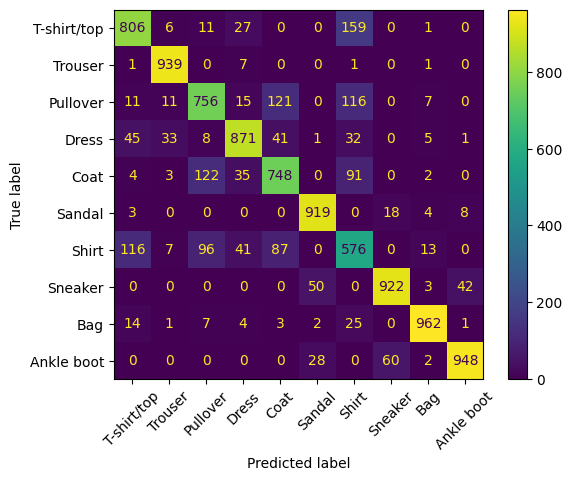

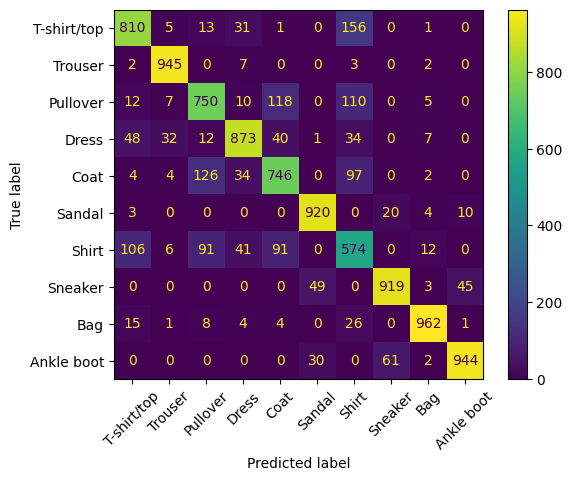

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hidden_repr_layers = get_hidden_repr_layers(test_set)
for i in range(len(hidden_repr_layers)):
  predictions = readouts[i](hidden_repr_layers[i]).max(axis=1).indices
  predictions = predictions.detach().to('cpu').numpy()
  true_values = test_set.targets.cpu().numpy()
  confmat = confusion_matrix(predictions, true_values)
  disp = ConfusionMatrixDisplay(confmat, display_labels=classes)
  disp.plot()
  plt.xticks(rotation = 45)
  plt.show()

### Psychometric curve

In [29]:
def inject_noise(dataset, noise_level):
  random = torch.randn(dataset.data.shape, device=device) * noise_level
  return dataset.data + random

In [30]:
def get_accuracy_values_at_noise_level(noise_level):
  test_set_with_noise = inject_noise(test_set.data, noise_level)  # first, let's create noisy test images
  hidden_repr_layers_noisy = get_hidden_repr_layers(test_set_with_noise)
  accuracy = []
  for i in range(len(hidden_repr_layers_noisy)):
    accuracy.append(compute_accuracy(readouts[i](hidden_repr_layers_noisy[i]), test_set.targets))
  return accuracy

In [31]:
noise_levels = [0.1*i for i in range(1, 10)]

for noise_level in noise_levels:
  acc = get_accuracy_values_at_noise_level(noise_level);
  print("===========================================")
  print(f"Noise level: {noise_level}")
  for i, accuracy in enumerate(acc):
    print(f"Accuracy of H{i+1} read-out: %.3f" % accuracy)

Noise level: 0.1
Accuracy of H1 read-out: 0.838
Accuracy of H2 read-out: 0.842
Accuracy of H3 read-out: 0.842
Accuracy of H4 read-out: 0.842
Noise level: 0.2
Accuracy of H1 read-out: 0.826
Accuracy of H2 read-out: 0.836
Accuracy of H3 read-out: 0.837
Accuracy of H4 read-out: 0.837
Noise level: 0.30000000000000004
Accuracy of H1 read-out: 0.813
Accuracy of H2 read-out: 0.825
Accuracy of H3 read-out: 0.826
Accuracy of H4 read-out: 0.828
Noise level: 0.4
Accuracy of H1 read-out: 0.788
Accuracy of H2 read-out: 0.806
Accuracy of H3 read-out: 0.811
Accuracy of H4 read-out: 0.816
Noise level: 0.5
Accuracy of H1 read-out: 0.759
Accuracy of H2 read-out: 0.785
Accuracy of H3 read-out: 0.791
Accuracy of H4 read-out: 0.796
Noise level: 0.6000000000000001
Accuracy of H1 read-out: 0.727
Accuracy of H2 read-out: 0.756
Accuracy of H3 read-out: 0.768
Accuracy of H4 read-out: 0.773
Noise level: 0.7000000000000001
Accuracy of H1 read-out: 0.700
Accuracy of H2 read-out: 0.730
Accuracy of H3 read-out: 0.74

In [32]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_by_layer = [[] for i in hidden_units]
  for noise_level in noise_levels:
    accs = get_accuracy_values_at_noise_level(noise_level)
    for i, acc in enumerate(accs):
      accuracy_values_by_layer[i].append(acc)

  fig, ax = plt.subplots()
  for accuracy_values in accuracy_values_by_layer:
    ax.plot(range(len(noise_levels)), accuracy_values)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "Fourth hidden", "Fifth hidden"])

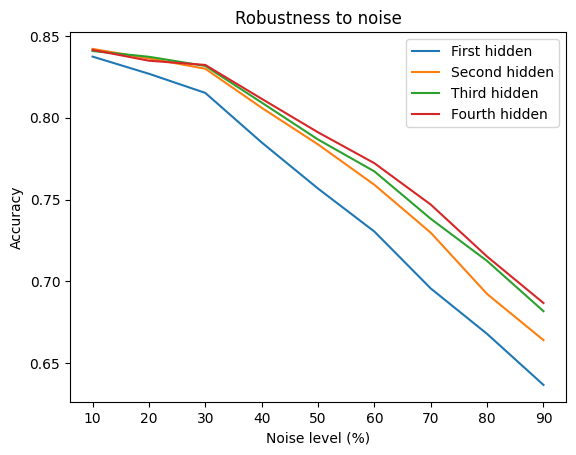

In [33]:
plot_noise_robustness_curves(noise_levels)

# 4. Response to adversarial attacks and the capability of few-shot learning

### Adversarial attack

In [34]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [35]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, custom_dbn, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.custom_dbn = custom_dbn
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.custom_dbn.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      p_v = image
      hidden_states = []
      for rbm in self.custom_dbn.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [36]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
            plt.show()



        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.custom_dbn.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), cmap="gray")
                plt.show()
                print_reconstruction = False

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [37]:
# show that first layer is more sensitive to noise
dbn_with_readout_first_layer = DBNWithReadOut(dbn_fmnist, readouts, readout_level=0)
dbn_with_readout_last_layer = DBNWithReadOut(dbn_fmnist, readouts, readout_level=len(hidden_units)-1)

In [38]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [39]:
# this can be set to observe changings in accuracy for different models
epsilon = 0.5

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



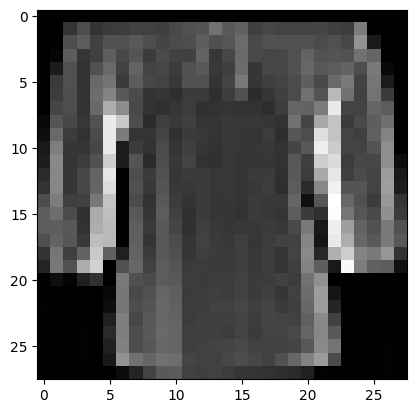


Here's a perturbed sample:



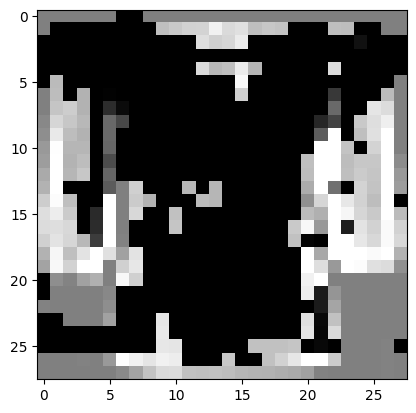


Here's what a 1-steps reconstructed sample looks like:



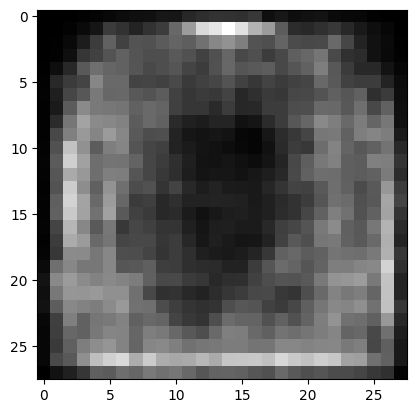


Epsilon: 0.5
Test Accuracy: 3.85%



In [40]:
test_last_layer = test_robustness_to_attack(
  dbn_with_readout_last_layer,
  device,
  test_loader,
  epsilon=epsilon,
  num_steps=1
)

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



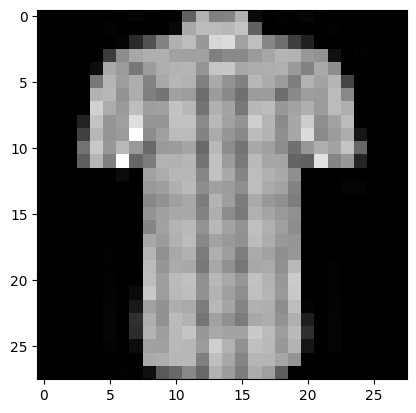


Here's a perturbed sample:



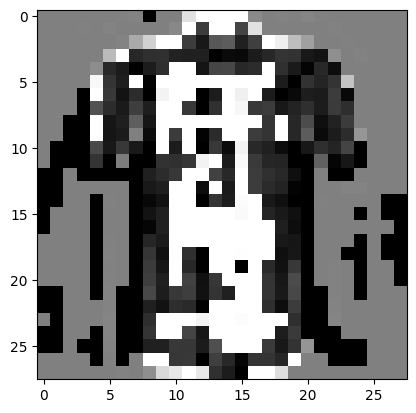


Here's what a 1-steps reconstructed sample looks like:



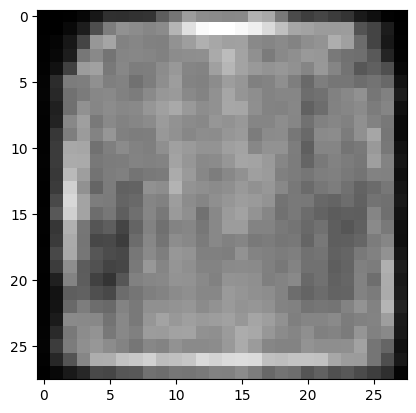


Epsilon: 0.5
Test Accuracy: 2.72%



In [41]:
test_last_layer = test_robustness_to_attack(
  dbn_with_readout_first_layer,
  device,
  test_loader,
  epsilon=epsilon,
  num_steps=1
)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [42]:
epsilon_values = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [43]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout_last_layer, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout_last_layer, n_steps=1)
accuracies_dbn_10 = test_epsilon_values_effect(dbn_with_readout_last_layer, n_steps=10)
accuracies_dbn_2 = test_epsilon_values_effect(dbn_with_readout_first_layer, n_steps=0)
accuracies_dbn_3 = test_epsilon_values_effect(dbn_with_readout_first_layer, n_steps=1)

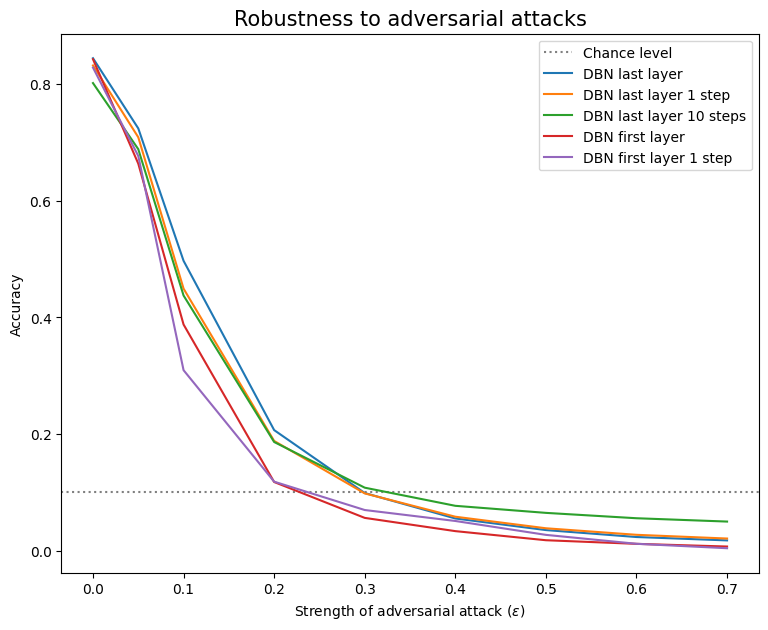

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.plot(epsilon_values, accuracies_dbn_10)
__ = ax.plot(epsilon_values, accuracies_dbn_2)
__ = ax.plot(epsilon_values, accuracies_dbn_3)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "DBN last layer", "DBN last layer 1 step", "DBN last layer 10 steps", "DBN first layer", "DBN first layer 1 step"])